# Heart Attack - Kaggle competition V 5.0  
### Author: Aniko Maraz, PhD

<br> <br> Note: This is the 2nd version of the improved model, currently running in production: 
<br> <br>
https://fake-heart-attack.streamlit.app/ <br> <br> 
This notebook includes an **XGBoost** model with **probability estimation**. This version is optimised for __*precision*__ (not accuracy as required on Kaggle).

I created this version because when predicting heart risk, not accuracy, but precision should be used, as the latter metric is a better indicator of how well the model picks up the positive cases. I also wanted to overcome the the possible shortcoming of the challenge, in which the best model (=highest accuracy) in Version 1 predicted all zeros (=low risk) on the ~1700 test cases, although in the train dataset there are ~35% positive cases. This indicates that the train and test datasets are possibly very different. The current version resulted in the prediction of 312 positive cases. 
<br> <br>
Data exploration, feature engineering, etc. can be found in [a previous version](https://github.com/anikomaraz/heart_attack_kaggle/blob/main/notebooks/heart_attack_v3_clean_KaggleV1.ipynb). 

Further info and versions in my [Git Repo](https://github.com/anikomaraz/heart_attack_kaggle). 

# Imports

In [11]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)

from xgboost import XGBClassifier, plot_importance

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    precision_recall_curve,
    recall_score,
    f1_score,
    roc_auc_score,
)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.model_selection import StratifiedKFold


import pickle

import jupyter_black

%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## DATA: GET AND EXPLORE

In [2]:
df_raw_train = pd.read_csv("../data/train.csv")

In [3]:
# def function to split blood pressure data (current format: 129/90)
def split_blood_pressure(df):
    df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic"] = pd.to_numeric(df["Systolic"])
    df["Diastolic"] = pd.to_numeric(df["Diastolic"])
    df.drop(columns=["Blood Pressure"], inplace=True)


# split cholesterol according to sample mean
cholesterol_sample_mean = df_raw_train["Cholesterol"].mean()


def split_cholesterol_sample(df):
    df["Cholesterol_sample_split"] = np.where(
        df["Cholesterol"] > cholesterol_sample_mean, 1, 0
    )


# create the new variables
df = df_raw_train.copy()

split_blood_pressure(df=df)
split_cholesterol_sample(df=df)

### Define features

In [4]:
# Defining the features and the target
X = df.drop(columns="Heart Attack Risk")
y = df["Heart Attack Risk"]

# Opt-in continuous and categorical variables
continuous_vars = [
    "Age",
    "Heart Rate",
    "Exercise Hours Per Week",
    "Stress Level",
    "Sedentary Hours Per Day",
    "Income",
    "BMI",
    "Triglycerides",
    "Physical Activity Days Per Week",
    "Sleep Hours Per Day",
    "Systolic",
    "Diastolic",
]

categorical_vars = [
    "Diabetes",
    "Family History",
    "Obesity",
    "Alcohol Consumption",
    "Previous Heart Problems",
    "Medication Use",
    "Cholesterol_sample_split",
    "Sex",
    "Continent",
    "Diet",
    "Hemisphere",
]

X_selected = X[continuous_vars + categorical_vars]

### Create preprocessing pipeline and train/test data

In [5]:
# Define preprocessing steps for continuous and categorical features
num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(drop="first")

preproc_basic = ColumnTransformer(
    transformers=[
        ("num", num_transformer, continuous_vars),
        ("cat", cat_transformer, categorical_vars),
    ],
    remainder="passthrough",
)

# Create pipelines for SVC
xgb_pipe = make_pipeline(preproc_basic, XGBClassifier(random_state=6))

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

## TRAIN AND TUNE THRESHOLD FOR PRECISION

In [6]:
# Fit the pipeline
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['Age', 'Heart Rate',
                                                   'Exercise Hours Per Week',
                                                   'Stress Level',
                                                   'Sedentary Hours Per Day',
                                                   'Income', 'BMI',
                                                   'Triglycerides',
                                                   'Physical Activity Days Per '
                                                   'Week',
                                                   'Sleep Hours Per Day',
                                                   'Systolic', 'Diastolic']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Diabetes', 'F...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=6, ...))])

In [7]:
# Save model
with open("../models/xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_pipe, f)

In [8]:
# Function to find the best threshold using cross-validation
def find_best_threshold_with_cv(train_probs, y_train, thresholds):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_threshold = 0.0
    best_precision = 0.0

    # Convert y_train to numpy array
    y_train = y_train.to_numpy()

    for threshold in thresholds:
        precisions = []
        for train_index, val_index in skf.split(train_probs, y_train):
            train_fold_probs, val_fold_probs = (
                train_probs[train_index],
                train_probs[val_index],
            )
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            val_predictions = (val_fold_probs > threshold).astype(int)
            precision = precision_score(y_val_fold, val_predictions, zero_division=1)
            precisions.append(precision)

        mean_precision = np.mean(precisions)
        if mean_precision > best_precision:
            best_precision = mean_precision
            best_threshold = threshold

    return best_threshold, best_precision


# Get predicted probabilities for the training set
train_probs = xgb_pipe.predict_proba(X_train)[:, 1]


# Evaluate thresholds
thresholds = np.linspace(0.0, 1.0, 100)
best_threshold, best_precision = find_best_threshold_with_cv(
    train_probs, y_train, thresholds
)

# Print the best threshold found
print(f"Best Threshold: {best_threshold:.2f}, Best Precision: {best_precision:.2f}")

Best Threshold: 0.62, Best Precision: 1.00


## Apply the best treshold to the test set

In [9]:
# Predict probabilities on the validation set
train_probs_val = xgb_pipe.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, train_probs_val)

# Ensure precision and recall are of the same length
precision = precision[:-1]
recall = recall[:-1]

# Compute combined metrics for each threshold
accuracies = []
f1_scores = []

for threshold in thresholds:
    test_predictions = (train_probs_val > threshold).astype(int)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)
    f1_scores.append(f1_score(y_test, test_predictions))

accuracies = np.array(accuracies)
f1_scores = np.array(f1_scores)

# Compute AUC
auc = roc_auc_score(y_test, train_probs_val)

# Find threshold that maximizes precision
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Metrics at the best threshold
best_precision = precision[best_threshold_index]
best_recall = recall[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]


print(
    f"Best Threshold: {best_threshold:.4f} with precision: {precision[best_threshold_index]:.4f} and accuracy: {best_accuracy:.4f}"
)

Best Threshold: 0.8505 with precision: 0.4286 and accuracy: 0.6400


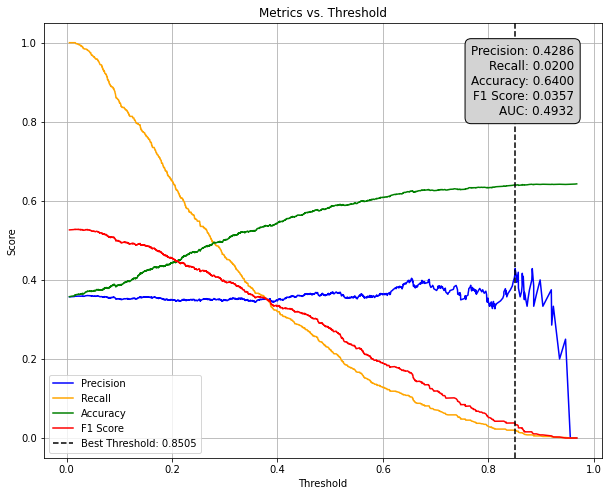

In [12]:
# Create the plot
plt.figure(figsize=(10, 8))

# Plot precision, recall, accuracy, and F1 score
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="orange")
plt.plot(thresholds, accuracies, label="Accuracy", color="green")
plt.plot(thresholds, f1_scores, label="F1 Score", color="red")

# Mark the best threshold
plt.axvline(
    x=best_threshold,
    color="black",
    linestyle="--",
    label=f"Best Threshold: {best_threshold:.4f}",
)

# Add text box with metrics at the best threshold
textstr = "\n".join(
    (
        f"Precision: {best_precision:.4f}",
        f"Recall: {best_recall:.4f}",
        f"Accuracy: {best_accuracy:.4f}",
        f"F1 Score: {best_f1_score:.4f}",
        f"AUC: {auc:.4f}",
    )
)
plt.gca().text(
    0.95,
    0.95,
    textstr,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightgrey"),
)

# Labels and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs. Threshold")
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig("../plots/model_xgb_proba_metrics.png")

plt.show()

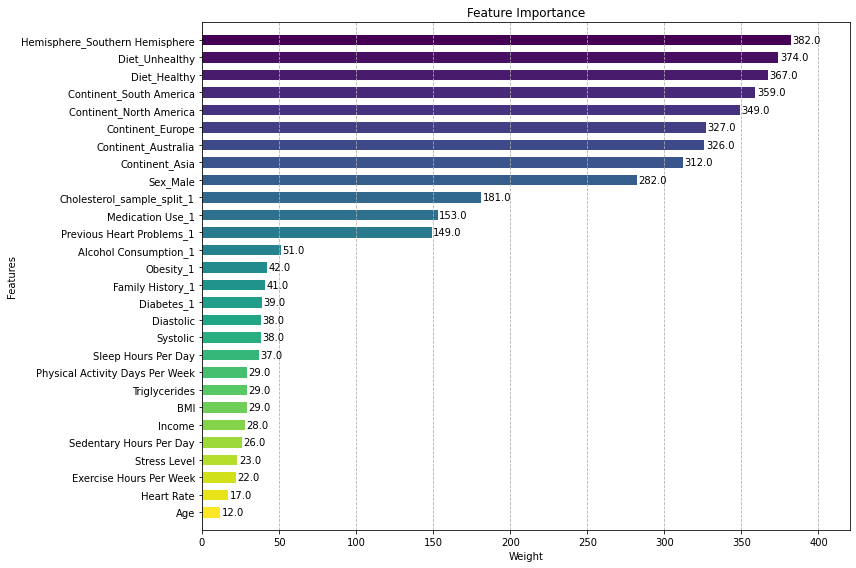

In [49]:
from matplotlib import cm

# Get number of features
num_features = len(feature_names_clean)

# Create custom colormap (using 'inferno' as a base)
custom_cmap = cm.get_cmap("viridis_r", num_features)


# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
plot_importance(
    xgb_pipe.named_steps["xgbclassifier"],
    ax=ax,
    height=0.6,
    importance_type="weight",
    xlabel="Weight",
    color=custom_cmap.colors,  
)

# Get feature names from preprocessor
feature_names = xgb_pipe.named_steps["columntransformer"].get_feature_names_out(
    input_features=X_train.columns
)

# pop the first 6 characters (num__ and cat__)
feature_names_clean = []
for feature in feature_names:
    feature_names_clean.append(feature[5:])

# Set new tick labels
ax.set_yticklabels(feature_names_clean)

ax.grid(True, axis="x", linestyle="--", zorder=0)
ax.grid(False, axis="y")

plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("../plots/model_xgb_feature_importance.png")
plt.show()

## Preprocess input data

In [50]:
df_kaggle_test = pd.read_csv("../data/test.csv")  # read in test data provided by Kaggle

# preprocess input data
df_kaggle_test = df_kaggle_test.copy()

split_blood_pressure(df=df_kaggle_test)
split_cholesterol_sample(df=df_kaggle_test)

X_df_kaggle_test_selected = df_kaggle_test[continuous_vars + categorical_vars]

## Predict on Kaggle test set and save submission

In [51]:
# Predict probabilities for the Kaggle test set
kaggle_test_probs = xgb_pipe.predict_proba(X_df_kaggle_test_selected)[:, 1]

# Apply the best threshold to Kaggle test set predictions
kaggle_test_predictions = (kaggle_test_probs > best_threshold).astype(int)

# Prepare submission dataframe
df_kaggle_test = pd.read_csv("../data/test.csv")
df_kaggle_predicted_V5 = {
    "Patient ID": df_kaggle_test["Patient ID"],
    "Heart Attack Risk": kaggle_test_predictions,
}
df_kaggle_predicted_V5_xgb_precision = pd.DataFrame(df_kaggle_predicted_V5)

In [52]:
# Save submission to CSV
df_kaggle_predicted_V5_xgb_precision.to_csv(
    "../submission/df_kaggle_predicted_V5_xgb_precision.csv", index=False
)

In [53]:
# Number of cases in the unseen Kaggle test set
len(df_kaggle_test)

1753

In [54]:
sum(kaggle_test_predictions)

27